In [1]:
from unityagents import UnityEnvironment
from collections import OrderedDict, deque

import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

In [2]:
env = UnityEnvironment(file_name="Banana.app")

brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
class Deep_Q_Network(nn.Module):

    def __init__(self, input_size, output_size, hidden_layers):
        '''
        input_size (int): Size of the input layer
        output_size (int): Size of the output layer
        hidden_layers (Array<int>): Sizes of each of the hidden layers
        '''

        super(Deep_Q_Network, self).__init__()
        self.layers = []

        self.layers.append(('fc_first', nn.Linear(input_size, hidden_layers[0])))
        self.layers.append(('relu_first', nn.ReLU()))

        i = 0
        while i < len(hidden_layers) - 1:
            self.layers.append(('fc_' + str(i), nn.Linear(hidden_layers[i], hidden_layers[i+1])))
            self.layers.append(('relu_' + str(i), nn.ReLU()))
            i += 1

        self.layers.append(('fc_last', nn.Linear(hidden_layers[len(hidden_layers) - 1], output_size)))
        
        self.parameters = nn.Sequential(OrderedDict(self.layers))


    def forward(self, state):
        calculation = state
        for layer in range(len(self.layers)):
            calculation = self.layers[layer][1](calculation)
        return calculation

In [4]:
hidden_layers = [128, 64]
max_memory = 100000
batch_size = 64
learning_rate = 0.0005
tau = 0.001
gamma = 0.99
update_every = 4

class Agent():
    
    def __init__(self, state_size, action_size, weights = None):
        self.state_size = state_size
        self.action_size = action_size
        
        self.network_local = Deep_Q_Network(self.state_size, self.action_size, hidden_layers)
        self.network_target = Deep_Q_Network(self.state_size, self.action_size, hidden_layers)
        
        if weights is not None:
            self.network_local.load_state_dict(weights)
            self.network_target.load_state_dict(weights)
            
        self.optimiser = optim.Adam(self.network_local.parameters(), lr = learning_rate)
        
        self.memory = deque(maxlen=max_memory)
        self.t_step = 0
        
    def get_action(self, state, epsilon = 0):
        
        state = torch.from_numpy(state).float().unsqueeze(0)
        
        self.network_local.eval()
        with torch.no_grad():
            actions = self.network_local(state)
        self.network_local.train()
        
        if random.random() > epsilon:
            return np.argmax(actions.detach().numpy())
        else:
            return random.choice(np.arange(self.action_size))
        
        
    def train(self, state, action, reward, next_state, done):
        self.memory.append({
            "state": state,
            "action": action,
            "reward": reward,
            "next_state": next_state,
            "done": done
        })
        
        self.t_step = (self.t_step + 1) % update_every
        if self.t_step == 0:
            if len(self.memory) > batch_size:
                experiences = random.sample(self.memory, k = batch_size)
                
                states = torch.from_numpy(np.vstack([e['state'] for e in experiences if e is not None])).float()
                actions = torch.from_numpy(np.vstack([e['action'] for e in experiences if e is not None])).long()
                rewards = torch.from_numpy(np.vstack([e['reward'] for e in experiences if e is not None])).float()
                next_states = torch.from_numpy(np.vstack([e['next_state'] for e in experiences if e is not None])).float()
                dones = torch.from_numpy(np.vstack([e['done'] for e in experiences if e is not None]).astype(np.uint8)).float()

                Q_targets_next = self.network_target(next_states).detach().max(1)[0].unsqueeze(1)
                Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
                Q_expected = self.network_local(states).gather(1, actions)
                
                loss = F.mse_loss(Q_expected, Q_targets)

                self.optimiser.zero_grad()
                loss.backward()
                self.optimiser.step()

                # Update params
                for target_param, local_param in zip(self.network_target.parameters(), self.network_local.parameters()):
                    target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
                

## TRAINING

Episode 100, Average 0.91
Episode 200, Average 3.56
Episode 300, Average 7.52
Episode 400, Average 9.97
Episode 500, Average 13.58
Episode 600, Average 13.86
Episode 700, Average 15.14
Episode 800, Average 14.64
Episode 900, Average 15.4
Episode 1000, Average 14.81


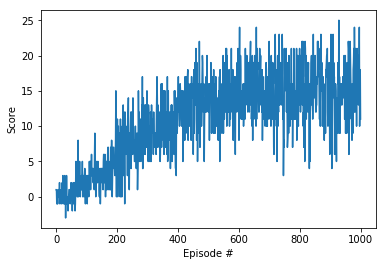

In [6]:
checkpoint_filename = 'checkpoint.pth'
number_of_episodes = 1000

epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.995
epsilon = epsilon_start

env_info = env.reset(train_mode=True)[brain_name]
state = env_info.vector_observations[0]
state_size = len(state)
action_size = brain.vector_action_space_size

agent = Agent(state_size, action_size)

all_scores = []
scores = deque(maxlen=100)

state_dict_score = 0

checkpoint = torch.load(checkpoint_filename)
if checkpoint:
    state_dict_score = checkpoint['score']

for episode in range(1, number_of_episodes + 1):
    env_info = env.reset(train_mode=True)[brain_name]
    state = env_info.vector_observations[0]
    episode_score = 0

    done = False
    while not done:
        action = agent.get_action(state, epsilon)
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]

        agent.train(state, action, reward, next_state, done)
        state = next_state
        
        # Save scores
        episode_score += reward


    epsilon = max(epsilon_end, epsilon_decay * epsilon)
    scores.append(episode_score)
    all_scores.append(episode_score)
    
    average_score = np.mean(scores)
    
    if episode % 100 == 0:
        print('Episode {}, Average {}'.format(episode, average_score))
    
    if average_score > state_dict_score:
        state_dict_score = average_score
        torch.save({
            "score": average_score,
            "state_dict": agent.network_local.state_dict()
        }, checkpoint_filename)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(all_scores)), all_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Playback

In [7]:
checkpoint_filename = 'checkpoint.pth'
checkpoint = torch.load(checkpoint_filename)

print('Loading checkpoint with score of ', checkpoint['score'])

env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations[0]
state_size = len(state)
action_size = brain.vector_action_space_size

agent = Agent(state_size, action_size, checkpoint['state_dict'])

done = False
while not done:
    action = agent.get_action(state)
    env_info = env.step(action)[brain_name]
    next_state = env_info.vector_observations[0]
    reward = env_info.rewards[0]
    done = env_info.local_done[0]
    state = next_state


Loading checkpoint with score of  17.35


In [8]:
## To close the unity environment
env.close()